<a href="https://colab.research.google.com/github/BreakoutMentors/Data-Science-and-Machine-Learning/blob/main/machine_learning/lesson%201%20-%20linear%20regression/examples/Multiple_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>Note: Always open this notebook in Colab for the best learning experience.

# Multiple Linear Regression: Can we predict life expectancy?

In our previous lesson, we explored the topic of single-variable linear regression and demonstrated how to build a linear model as a single-layer neural network. In single-variable regression analysis, there is only one independent variable (i.e., x variable) and one dependent variable (i.e., y variable). However, what if we want to build a model to predict a label given multiple x variables (i.e., features)? To achieve this, we use multiple linear regression--a method to model the relationship between a dependent variable (y) and multiple independent variables (x). Intuitively, adding more x (in this case x columns) data to our features tends to help the model improve its overall performance.

While adding more variables allows us to model more complex "real-world" relationships there are also additional steps we must take to make sure our model is sound and robust.

In this lesson, we introduce the multiple linear regression method and demonstrate how to build a multiple linear regression model to predict life expectancy using the same [Life Expectancy(WHO)](https://www.kaggle.com/kumarajarshi/life-expectancy-who) dataset from the previous lesson. 


## Multiple Linear Regression
Before we discuss multiple linear regression, let's review single-variable linear regression. Recall that single-variable linear regression aims to fit a line to the data using the following formula: 
$$
\hat{y} = wx + b
$$
where $w$ is known as the *weight*, and $b$ is   the *bias* term.

When the inputs ($x$) consists of $d$ features, we express the above linear function as: 
$$
\hat{y} = w_1  x_1 + ... + w_d  x_d + b.
$$

In machine learning, we typically work with *high-dimensional* datasets, meaning $d$ is large so there are many features. When $d$ is large, it's not convenient to write the above linear equation, instead we can express it using vector notation as follows:
$$
\hat{y} = \mathbf{w}^\top \mathbf{x} + b.
$$

where the vector $\mathbf{x} \in \mathbb{R}^d$ and the vector $\mathbf{w} \in \mathbb{R}^d$  contain the *features* and *weights* respectively.

In the above equation, $\mathbf{x}$ corresponds to a single input sample. It is often more convenient to refer to features of our entire dataset of $n$ samples via the *matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$, where each sample is represented by a row and each feature by a column. For a collection of features $\mathbf{X}$ and labels $y \in \mathbb{R^n}$, the multiple linear regression function can be expressed as the matrix-vector product:

$$
{\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b.
$$

The goal of multiple linear regression is to find the weight vector  $\mathbf{w}$  and the bias term  $b$  that results in the lowest prediction error. Notice that the goal is basically the same as single-variable linear regression except multiple weights are learned instead of one.

The figure below illustrates a single-layer multiple linear regression neural network. The input layer consists of $d$ *neurons* each corresponding to a feature (from $\mathbf{x}$) and $d$ *connections* each corresponding to the *weight* between the output neuron an input neuron. 

<figure>
<img src='https://d2l.ai/_images/singleneuron.svg' width='60%'></img><figcaption>Linear Regression: a multiple linear regression neural network</figcaption>
</figure>




# Multiple Linear Regression: Can we predict life expectancy?
Now that we know a bit about the multiple linear regression method, it's time to apply it to a real-world problem--predicting life expectancy given other health statistics. Our goal is to build a *single-layer fully-connected neural network* (i.e., a mutliple linear regression model) to predict life expectancy using the WHO's [Life Expectancy](https://www.kaggle.com/kumarajarshi/life-expectancy-who) dataset.

Like single-variable linear regression, we will perform the following steps:

1. Explore and prepare the dataset.
2. Build the model.
3. Train the model.
4. Evaluate the model.
5. Draw conclusions.


In [1]:
# Import the libraries we be need.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import PyTorch.
import torch
import torch.nn as nn

## 1. Explore and prepare the dataset


In [2]:
# load the dataset into a dataframe
data_url = 'https://raw.githubusercontent.com/BreakoutMentors/Data-Science-and-Machine-Learning/main/datasets/Life%20Expectancy%20Data.csv'
df = pd.read_csv(data_url)
df.columns = [col_name.strip() for col_name in df.columns] # used to fix weird spaces in the column names
df.head() # view the first 5 rows of the data

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# Looking at null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [4]:
# First action of cleaning is to remove the rows with life expectancy nans
df = df.loc[~df['Life expectancy'].isna(), :]

print('The amount of columns that will be deleted if we deleted all rows with Nans:', df.shape[0] - df.dropna().shape[0])
print('That is a really high number! We should replace those values')
# Second action is to fill all other Nans 
fillers = {'Alcohol':df['Alcohol'].mean(), 'Hepatitis B':df['Hepatitis B'].mean(),
           'BMI':df['BMI'].mean(), 'Polio':df['Polio'].mean(),
           'Total expenditure':df['Total expenditure'].mean(),
           'Diphtheria':df['Diphtheria'].mean(), 'GDP':df['GDP'].mean(),
           'Population':df['Population'].mean(),
           'thinness  1-19 years':df['thinness  1-19 years'].mean(),
           'thinness 5-9 years':df['thinness 5-9 years'].mean(),
           'Income composition of resources':df['Income composition of resources'].mean(),
           'Schooling':df['Schooling'].mean()}

df = df.fillna(value=fillers)
print('The amount of Nans still left:', df.isna().sum().sum())

The amount of columns that will be deleted if we deleted all rows with Nans: 1279
That is a really high number! We should replace those values
The amount of Nans still left: 0


There are three variables we don't want to use in our model: Country, Year, Status. The reason why we do not want these variables is because they do not describe any information about health or wealth, and we do not want the location and year to have influence in the model. In the below cell, we will remove those variables and prepare the dataset for the model. Remember this process involves defining the features ($\mathbf{x}$) and the labels ($y$), splitting the dataset into a training and test set, and separating the features and the labels in both sets. In this case, the features will be all the other variables except life expectancy, which is our labels.

In [5]:
# Dropping Country, Year and Status from dataframe
df = df.drop(columns=['Country', 'Year', 'Status'])

# define the x (features) and y (labels) variables
x_cols = df.drop(columns=['Life expectancy']).columns.tolist()
y_col = 'Life expectancy'
print('x features: ', x_cols)
print('y labels: ', y_col)


# Calculating means and stds to normalize data
means = df.loc[:, x_cols].mean().values
stds = df.loc[:, x_cols].std().values

# split the dataset into train/test datasets 
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

# Splitting training data into validation data
valid = train.sample(frac=0.1, random_state=0)
train = train.drop(valid.index) # Deleting rows sampled for validation data

# separate the x (features) and y (labels) in the train/valid/test datasets and normalizing them
train_features = torch.tensor((train[x_cols].values-means)/stds, dtype=torch.float)
test_features = torch.tensor((test[x_cols].values-means)/stds, dtype=torch.float)
valid_features = torch.tensor((valid[x_cols].values-means)/stds, dtype=torch.float)

train_labels = torch.tensor(train[y_col].values.reshape(-1, 1), dtype=torch.float)
test_labels = torch.tensor(test[y_col].values.reshape(-1, 1), dtype=torch.float)
valid_labels = torch.tensor(valid[y_col].values.reshape(-1, 1), dtype=torch.float)

print('train features shape:', train_features.shape)
print('train labels shape:', train_labels.shape)

print('validation features shape:', valid_features.shape)
print('validation labels shape:', valid_labels.shape)

print('test features shape:', test_features.shape)
print('test labels shape:', test_labels.shape)

print('first 5 test labels:\n', test_labels[:5])

x features:  ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling']
y labels:  Life expectancy
train features shape: torch.Size([2108, 18])
train labels shape: torch.Size([2108, 1])
validation features shape: torch.Size([234, 18])
validation labels shape: torch.Size([234, 1])
test features shape: torch.Size([586, 18])
test labels shape: torch.Size([586, 1])
first 5 test labels:
 tensor([[65.0000],
        [59.5000],
        [58.1000],
        [76.2000],
        [75.9000]])


The above code returns a training, validation, and test datasets. The `x features:` printed line above shows the 18 variables chosen as our *features*, such as Alcohol usage, BMI, and GDP. And the Life expectancy variable represents the *labels*. There are three datasets--a *training dataset*, a *validation dataset* and a *test dataset*. The `train_features` and `train_labels` arrays represent the features and labels of the training dataset, each containing 2108 samples. The `valid_features` and `valid_labels` arrays represent the features and labels of the validation dataset, each containing 234 samples.  The `test_features` and `test_labels` arrays represent the features and labels of the test dataset, each containing 586 samples.  

Now that we have the *features* and *labels* separated, we are ready to build our model!

## 2. Build the model
Now that the data is ready, we can build the model! 

Before we define the model in Python code, let's write out its function given one input sample:
$$
\hat{\text{Life Expectancy}} = w_1 x_1 + w_2 x_2 + ... + w_{16} x_{16} + w_{17} x_{17} + w_{18} x_{18} + b,
$$
where 1-18 corresponds to one of the feature column we defined earlier (i.e., GDP, BMI, etc.). The function can be compressed using vector notation as:
$$ 
\hat{\text{Life Expectancy}} = \mathbf{w}^\top \mathbf{x} + b.
$$

Given the entire training set, we write the matrix-vector equation for our linear model as:
$$
{\hat{\textbf{Life Expectancy}}} = \mathbf{X} \mathbf{w} + b.
$$

The model we build and then train will try to find the optimal *weights* ($\mathbf{w}$) to minimize the difference between the real labels ($\textbf{Life Expectancy}$) and the predictions ($\hat{\textbf{Life Expectancy}})$.

Now that we know the function we want to estimate, let's use [PyTorch](https://pytorch.org/) to build a linear regression model, just like we did in the last lesson. However, we are adding one parameter to the constructor of the class called `num_features`, which is the number of feature variables to add some customizability in the construction of our model.


In [6]:
# build the linear model 
class LR_Model(nn.Module):
    """
    @params
        num_features(int): The number of features to construct the input layer of the NN
    """
    # Defining Constructor
    def __init__(self, num_features):
        super(LR_Model, self).__init__()

        # Defining Layers
        self.fc1 = nn.Linear(num_features, 1)

    def forward(self, x):
        return self.fc1(x)

# Initializing model
num_features = train_features.shape[1] # Getting number of features
model = LR_Model(num_features)

print('Model Summary')
print(model)

Model Summary
LR_Model(
  (fc1): Linear(in_features=18, out_features=1, bias=True)
)


The model we defined above is a multiple linear model that could also be called a *single-layer fully-connected neural network*. We defined it using the [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) class. Note that we passed two arguments into the `torch.nn.Linear` class. The first one specifies the input feature dimension, which is 18 (corresponding to the number of x features in `train_features`), and the second one is the output feature dimension, which is a single scalar and therefore 1. Each input *feature* has a corresponding *weight* and there is one bias term. The *weights* and *bias*, or *parameters*, are connected to the single output *neuron*.

### Define the loss function and optimization algorithm

After defining the model, we need to configure the *loss function*, *optimization algorithm* for the model. We will use mean squared error for the loss function and stochastic gradient descent (SGD) for the optimization algorithm.

In [7]:
# Defining Loss Function
loss_fn = nn.MSELoss()

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## 3. Train the model
Now that we have a model, it's time to train it. We will train the model for 100 *epochs* (i.e., iterations), and record the training losses and validation losses for every epoch.

In [8]:
# Try this

epochs = 100
train_losses = []
valid_losses = []
for epoch in range(1, epochs+1):

    ###################
    # train the model #
    ###################

    # Setting model to train mode
    model.train()
    
    # Setting all gradients to zero
    optimizer.zero_grad()

    # Calculate Output
    train_predictions = model(train_features)
        
    # Calculate Loss
    train_loss = loss_fn(train_predictions, train_labels)

    # Calculate Gradients
    train_loss.backward()

    # Perform Gradient Descent Step
    optimizer.step()

    ######################    
    # validate the model #
    ######################

    # Setting model to evaluation mode, no parameters will change
    model.eval()

    # Calculate Output
    valid_predictions = model(valid_features)

    # Calculate Loss
    valid_loss = loss_fn(valid_predictions, valid_labels)

    # Saving Losses
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 4927.366699 	Validation Loss: 3122.039062
Epoch: 2 	Training Loss: 3108.438721 	Validation Loss: 2013.896606
Epoch: 3 	Training Loss: 1992.411743 	Validation Loss: 1313.419434
Epoch: 4 	Training Loss: 1280.363037 	Validation Loss: 862.721375
Epoch: 5 	Training Loss: 825.485901 	Validation Loss: 572.756470
Epoch: 6 	Training Loss: 534.722473 	Validation Loss: 385.774933
Epoch: 7 	Training Loss: 348.769775 	Validation Loss: 264.890045
Epoch: 8 	Training Loss: 229.793015 	Validation Loss: 186.468887
Epoch: 9 	Training Loss: 153.635147 	Validation Loss: 135.362579
Epoch: 10 	Training Loss: 104.863373 	Validation Loss: 101.853638
Epoch: 11 	Training Loss: 73.613876 	Validation Loss: 79.704132
Epoch: 12 	Training Loss: 53.579807 	Validation Loss: 64.906311
Epoch: 13 	Training Loss: 40.727196 	Validation Loss: 54.882664
Epoch: 14 	Training Loss: 32.474895 	Validation Loss: 47.973129
Epoch: 15 	Training Loss: 27.170683 	Validation Loss: 43.107002
Epoch: 16 	Training Lo

We get to ~19 validation mean squared error after training for 100 epochs on the training dataset. For reference, the same metric was ~172 in the single-variable linear regression model (from the previous lesson).  Let's visualize the model's training progress.



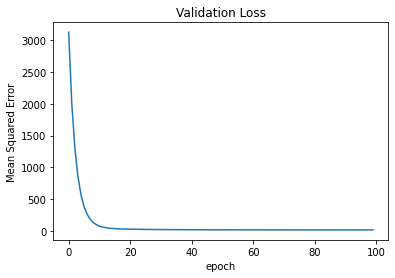

In [9]:
plt.plot(valid_losses)
plt.xlabel('epoch')
plt.ylabel('Mean Squared Error')
plt.title('Validation Loss')
plt.show()

From the plot we can see that our model *converges* evenly throughout the 100 epochs, but it seems to *converge* at epoch 100. In other words, the most optimal parameters (weights and bias) are found after about the 100th training iteration. 

## 4. Evaluate the model
Now that we trained our model, it's time to evaluate it using the *test* dataset, which we did not use when training the model. This gives us a sense of how well our model predicts unseen data, which is the case when we use it in the real world.

In [10]:
# Setting model to evaluation mode
model.eval()

# Getting Predictions
test_predictions = model(test_features)

# Calculating loss, which is the Mean Squared Error
loss = loss_fn(test_predictions, test_labels)

print('Test set Mean Squared Error: ', round(loss.item(), 4))

Test set Mean Squared Error:  16.676


The mean squared error is around ~16, which is better than the single-variable linear model ~134. Is this good? We'll leave that decision up to you. Let's also visualize the prediction and real life expectancy values using data in the test set.

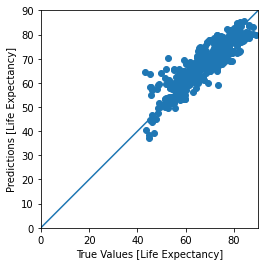

In [11]:
# Flattening test predictions
test_predictions = test_predictions.flatten().detach().numpy()

# Getting higher boundary
if max(test_labels) < max(train_labels):
    higher_boundary_lim = int(max(train_labels))
else:
    higher_boundary_lim = int(max(test_labels))

ax = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Life Expectancy]')
plt.ylabel('Predictions [Life Expectancy]')

lims = [0, higher_boundary_lim + 1] # [0, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

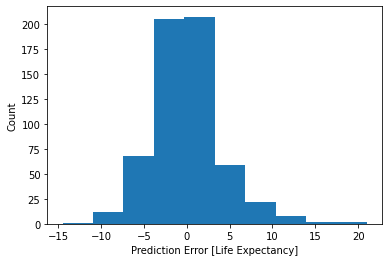

In [12]:
error = test_predictions - test_labels.flatten().detach().numpy()
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [Life Expectancy]")
_ = plt.ylabel("Count")

The histogram shows that the errors are somewhat *Normally distributed* (also called *gaussian*), since we see that most errors are close to 0.

## 5. Draw Conclusions
We built a single-layer fully-connected neural network model (multiple linear regression model) to predict life expectancy given a country's features. The model converged after about 100 epochs of training, and it achieved a test mean squared error of ~16. Including more features in the model outperformed the single-variable linear regression model, confirming the hypothesis we made last lesson that more features could improve performance. That said, we expect that a *deeper* model (more layers and neurons) and more data samples will improve performance.     

# Summary
In this lesson we took a deeper dive into multiple regression, from the perspective of neural networks. We built a single-layer fully-connected neural network and demonstrated how to train and evaluate it. We covered several important techniques, most importantly: using multiple features to train a linear model.